# FIGURE 2 - macroecological patterns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ishealthy = pd.read_parquet(path="../DATA/metadata/remapped/sample_health.parq")["ishealthy"]
functional_table = pd.read_parquet("../DATA/datasets/remapped/functional_table.parq")

from utils import normalize_vec, split_dataset, rescale_dataset
from utils import asymmetric_std, rolling_average, add_binw_patch

## Compute

Computation of the data underlying the plots

### MAD

In [2]:
# MAD
def compute_MAD(dataset,ishealthy,nbins=30,window=1,resolution=10):
    Hds,Uds = split_dataset(dataset,ishealthy)

    # compute mean abundances
    mean_H = Hds.mean(axis=1)
    mean_U = Uds.mean(axis=1)

    # define domain extrema
    vmin = min(mean_H[mean_H>0].min(),mean_U[mean_U>0].min())
    vmax = max(mean_H.max(),mean_U.max())

    # define bins position
    bins = np.logspace(np.log10(vmin),np.log10(vmax),nbins*resolution+1)

    
    Hhist = np.histogram(mean_H,bins=bins)[0]
    Uhist = np.histogram(mean_U,bins=bins)[0]

    MAD = pd.DataFrame({"bins_center": 0.5*(bins[1:]+bins[:-1]),
                        "Hhist"      : normalize_vec(Hhist), # histrogram with log-density normalization
                        "Uhist"      : normalize_vec(Uhist),
                        "Hcounts"    : Hhist,
                        "Ucounts"    : Uhist        })
    MAD.set_index("bins_center",drop=True,inplace=True)

    if window is not None:
        MAD = rolling_average(MAD,window=window*resolution)
        MAD[["Hcounts","Ucounts"]] *= window*resolution
        MAD.logbinw = (np.log10(vmax)-np.log10(vmin))/(nbins+1)*window
    else:
        MAD.logbinw = None

    return MAD

### OA relation

In [3]:
# function that binns the OA "scatterplot" to produce a curve of average O vs average A within the assigned A bin
def binning(OA,vmin,vmax,nbins=30,window=1,resolution=13):
    OA = OA.sort_values(OA.columns[1])

    # define domain extrema and binning
    bins = np.logspace(np.log10(vmin),np.log10(vmax),nbins*resolution+1)

    # selection vector
    bin_idxs = np.digitize(OA.iloc[:,1],bins=bins)

    OA["select"] = bin_idxs

    # bin all columns together
    def aggfunc(row):
        occ, abu = row.columns[:2]
        res = pd.Series()
        res["O_mean"]                = row[occ].mean()
        res["A_mean"]                = row[abu].mean()
        res["O_std-"], res["O_std+"] = asymmetric_std(row[occ], axis=0)
        res["A_std-"], res["A_std+"] = asymmetric_std(row[abu], axis=0)
        res["n"]                     = len(row)
        return res

    # create coupled hystogram
    binned_OA = OA.groupby(bin_idxs).apply(aggfunc) 
    
    
    ## fill missing bins, pad, and roll (does not compute correctly the +- std values: sensitive to resolution parameter)
    missing_index = pd.Index(set(range(len(bins)-1))-set(binned_OA.index))                       # create list of missing indexes
    binned_OA = pd.concat([ binned_OA, pd.DataFrame(index=missing_index) ],axis=0 ).sort_index() # insert, and sort
    
    if window is not None:
        binned_OA = rolling_average(binned_OA,window=window*resolution) # rolling average
    #else:
        #binned_OA = binned_OA.fillna(0)

    return binned_OA


# compute occurence abundance values or binned average curve
def compute_OA(dataset, ishealthy,thr=0,nbins=None,window=None,resolution=1):

    Hds, Uds = split_dataset(dataset,ishealthy)

    # compute mean std values
    OA = pd.DataFrame({("H","occurrence") : (Hds>thr).mean(axis=1),
                       ("H","abundance" ) :  Hds.mean(axis=1)   ,
                       ("U","occurrence") : (Uds>thr).mean(axis=1),
                       ("U","abundance" ) :  Uds.mean(axis=1)      })

    # binning
    if nbins is not None:
        vmin = 1e-11 # 1e-8 (for unnormalized functional dataset)
        vmax = max(OA[("H","abundance")].max(),OA[("U","abundance")].max())
        OA = pd.concat({"H":binning(OA["H"],vmin,vmax,nbins=nbins,window=window,resolution=resolution),
                        "U":binning(OA["U"],vmin,vmax,nbins=nbins,window=window,resolution=resolution) },axis=1)
        OA.index.name = "bin_idx"
        if window is not None:
            OA.logbinw = (np.log10(vmax)-np.log10(vmin))/(nbins+1)*window
        else:
            OA.logbinw = None

    return OA


### Marginals (for SAD and AFD)

In [4]:
# Marginal distributions SAD/MAD
def compute_marginal(dataset,ishealthy,kind,nbins=10,window=None,resolution=1,rescale=False):
    assert kind=="SAD" or kind=="AFD"
    axis = 0 if kind=="AFD" else 1 # direction to be converted into histogram

    if rescale: dataset = rescale_dataset(dataset,axis=axis,log_scaling=True)
    Hds,Uds = split_dataset(dataset,ishealthy)

    # binning
    # define domain extrema
    vmin = max( 1e-6, dataset[dataset>0].min().min() )
    vmax = min( 1e6 , dataset           .max().max() )

    # define bins position
    bins = np.logspace(np.log10(vmin),np.log10(vmax),nbins*resolution+1)
    bins_center = pd.Index(0.5*(bins[1:]+bins[:-1]))
    bins_center.name = "bins_center"
    
    # in both cases I waht the bins_center as index
    if kind=="SAD":
        Hds = Hds.T
        Uds = Uds.T

    # concat with multiindex on columns
    hists = pd.concat({
        # histrograms with log-density normalization
        "H": Hds.apply(lambda x: normalize_vec( np.histogram(x,bins=bins)[0] ), axis=0).set_index(bins_center),
        "U": Uds.apply(lambda x: normalize_vec( np.histogram(x,bins=bins)[0] ), axis=0).set_index(bins_center)
    },axis=1)

    # rolling average
    if window is not None:
        hists = rolling_average(hists,window=window*resolution)
        hists.logbinw = (np.log10(bins[1])-np.log10(bins[0]))*window*resolution
    else:
        hists.logbinw = None

    return hists


### Compute all

In [5]:
def compute_figure_2(dataset,ishealthy,nbins=12,window=1,resolution=10):

    OA = (compute_OA(dataset,ishealthy),compute_OA(dataset,ishealthy,nbins=nbins,window=window,resolution=resolution))
    MAD = compute_MAD(dataset,ishealthy,nbins=nbins,window=window,resolution=resolution)
    SAD = compute_marginal(dataset,ishealthy,kind="SAD",nbins=nbins*2,window=window,resolution=resolution,rescale=True)
    AFD = compute_marginal(dataset,ishealthy,kind="AFD",nbins=nbins  ,window=window,resolution=resolution,rescale=False)

    return (OA,MAD,SAD,AFD)


DATA = compute_figure_2(functional_table,ishealthy)

## Plot

Plotting the precomputed data

In [6]:
# define default value for params
default_params = {}
default_params["H"] = {"linestyle" : "-" , 
                       "alpha"     : 0.9 ,
                       "linewidth" : 0.45,
                       "color"     : "dodgerblue" }
default_params["U"] = {"linestyle" : "--" , 
                       "alpha"     : 0.9 ,
                       "linewidth" : 0.45,
                       "color"     : "darkorange" }

### Subplots

  * The fAFD (functional Abundance Fluctuation Distribution) is the property of a single function, and registers the statistics of its abundances over the different samples
  * The fSAD (functional Species Abundance Distribution) is the property of a single sample, and registers the statistics of the abundances with which the various functions are observed in it.
  * The fMAD (functional Mean Abundance Distribution) is a property of the whole dataset, and registers the statistics of the averages (over the samples) of the abundances of the functions.
  * The fOAC (functional Occurrence Abundance Curve) is a property of the whole dataset, and displays the relation between the mean abundance and the occurrence of each function.

#### MAD

In [7]:
def visualize_MAD(MAD,ax=None,title="MAD",params=default_params,show_counts=False):

    # menage figure
    show=False
    if ax is None:
        fig, ax = plt.subplots(1,1)
        show=True
    
    # reconstruct actual bin edges
    #bins = reconstruct_bins(bins_center=MAD.index, logbins=True)
    
    # plot
    ax.set_title(title)
    if show_counts: # show the counts for each bin (how good is the choich of the binning length?)
        ax.plot(MAD.index,MAD["Hcounts"],**params["H"])
        ax.plot(MAD.index,MAD["Ucounts"],**params["U"])
    else:
        ax.plot(MAD.index,MAD["Hhist"],**params["H"])
        ax.plot(MAD.index,MAD["Uhist"],**params["U"])

    #label
    ax.set_xlabel("Mean Abundance")
    if show_counts:
        ax.set_ylabel("log-counts")
    else:    
        ax.set_ylabel("log-density")
    
    # scales
    ax.set_xscale("log")
    ax.set_yscale("log")

    # binw patch
    if MAD.logbinw is not None:
        add_binw_patch(ax,MAD.logbinw)

    
    # show
    if show:
        ax.legend()
        plt.show()

#### OA

In [8]:
def visualize_OA(OA,OAbin,ax=None,title=None,left_crop=1e-7,showerror=False,scatterplot=True,params=default_params):
    
    # manege figure
    show=False
    if ax is None:
        fig, ax = plt.subplots(1,1)
        show=True

    ax.set_title(title)

    ## PLOT1: scatter single points

    if scatterplot:
        # randomize order of plotting to avoid baias in coloring
        p = np.random.permutation(2*len(OA))
        abundance = pd.concat([OA["H"]["abundance"] , OA["U"]["abundance" ]]).iloc[p]
        occurrence= pd.concat([OA["H"]["occurrence"], OA["U"]["occurrence"]]).iloc[p]
        color     = np.repeat([params["H"]["color"],params["U"]["color"]],[len(OA["H"]),len(OA["U"])],axis=0)[p]

        # scatter plot
        ax.scatter(abundance, occurrence, color=color,alpha=0.025)


    ## PLOT2: curces binned values

    Hmask = OAbin["H"]["A_mean"]>left_crop
    Umask = OAbin["U"]["A_mean"]>left_crop

    # prepare data
    Hx      = OAbin["H"]["A_mean"].loc[Hmask]
    Hy      = OAbin["H"]["O_mean"].loc[Hmask]
    Ux      = OAbin["U"]["A_mean"].loc[Umask]
    Uy      = OAbin["U"]["O_mean"].loc[Umask]

    # error region
    if showerror:
        Uye_neg = OAbin["U"]["O_std-"].loc[Umask]
        Uye_pos = OAbin["U"]["O_std+"].loc[Umask]
        Hye_neg = OAbin["H"]["O_std-"].loc[Hmask]
        Hye_pos = OAbin["H"]["O_std+"].loc[Hmask]
        ax.fill_between(x=Hx,y1=Hy-Hye_neg,y2=Hy+Hye_pos,color=params["H"]["color"],edgecolor=params["H"]["color"],alpha=0.12)
        ax.fill_between(x=Ux,y1=Uy-Uye_neg,y2=Uy+Uye_pos,color=params["U"]["color"],edgecolor=params["U"]["color"],alpha=0.15)
    
    # bined values
    ax.plot(Hx,Hy,**params["H"])
    ax.plot(Ux,Uy,**params["U"])


    ## TWEAK

    # labels
    ax.set_xlabel("Mean Abundance")
    ax.set_ylabel("Mean Occurrence")

    # scale
    ax.set_xscale("log")
    
    # patches
    if OAbin.logbinw is not None:
        add_binw_patch(ax,OAbin.logbinw)
    
    # show
    if show:
        ax.scatter([np.nan],[np.nan],color=params["H"]["color"],label="H")
        ax.scatter([np.nan],[np.nan],color=params["U"]["color"],label="U")
        ax.legend()
        plt.show()


#### Marginals (for SAD and AFD)

In [9]:
def visualize_marginal(hists,ax=None,kind="SAD",logy=True,n_sampl=12,showerror=False,params=default_params):

    # fraction of surviving curves (for each bin), keep only meaningful range
    cutoff = 1e-7
    fsurv = (hists>cutoff).sum(axis=1)/len(hists.columns)
    logbinw = hists.logbinw
    hists = hists.loc[fsurv>0.5]
    hists.logbinw = logbinw


    # menage figure
    show=False
    if ax is None:
        fig, ax = plt.subplots(1,1)
        show=True    
    

    # underimpose some data from the original distributions
    if n_sampl>0:
        for a,b in zip(np.random.choice(hists["H"].columns,n_sampl//2),np.random.choice(hists["U"].columns,n_sampl//2)):
            ax.plot(hists.index[hists["H"][a]>0],hists["H"][a][hists["H"][a]>0],linestyle="--",linewidth=0.1)
            ax.plot(hists.index[hists["U"][b]>0],hists["U"][b][hists["U"][b]>0],linestyle="--",linewidth=0.1)

    # errorbars
    ax.set_title(kind)
    if showerror:
        # reconstruct actual bin edges
        #bins = reconstruct_bins(bins_center=hists.index, logbins=True)
        fillalpha = {"H":0.08,"U":0.10} 
        def plot_errorrange(HU):
            center =                hists[HU].mean(axis=1)
            astd   = asymmetric_std(hists[HU],axis=1)
            ax.fill_between(x=hists.index,y1=center-astd[0],y2=center+astd[1],color=params[HU]["color"],alpha=fillalpha[HU])
            #ax.stairs(baseline=center-astd[0],values=center-astd[0],edges=bins,fill=True,color=color,alpha=0.2)
        plot_errorrange("H")
        plot_errorrange("U")

        #ax.errorbar(hists.index,hists["H"].mean(axis=1),asymmetric_std(hists["H"],axis=1),capsize=2,color=Hcol)
        #ax.errorbar(hists.index,hists["U"].mean(axis=1),asymmetric_std(hists["U"],axis=1),capsize=2,color=Ucol)
    
    ax.plot(hists.index,hists["H"].mean(axis=1),**params["H"],label="H")
    ax.plot(hists.index,hists["U"].mean(axis=1),**params["U"],label="U")

    # labels
    ax.set_xlabel("Abundance")
    ax.set_ylabel("logbin density")
    
    # scales
    ax.set_xscale("log")
    if logy: ax.set_yscale("log")

    # range
    #ax.set_xlim(bottom=1e-5)
    ax.set_ylim(bottom=1e-5)
    
    # patches
    add_binw_patch(ax,hists.logbinw,axes_y0=0.05)
    
    #ax.grid(True)

    # show
    if show:
        ax.legend()
        plt.show()

### Plot all

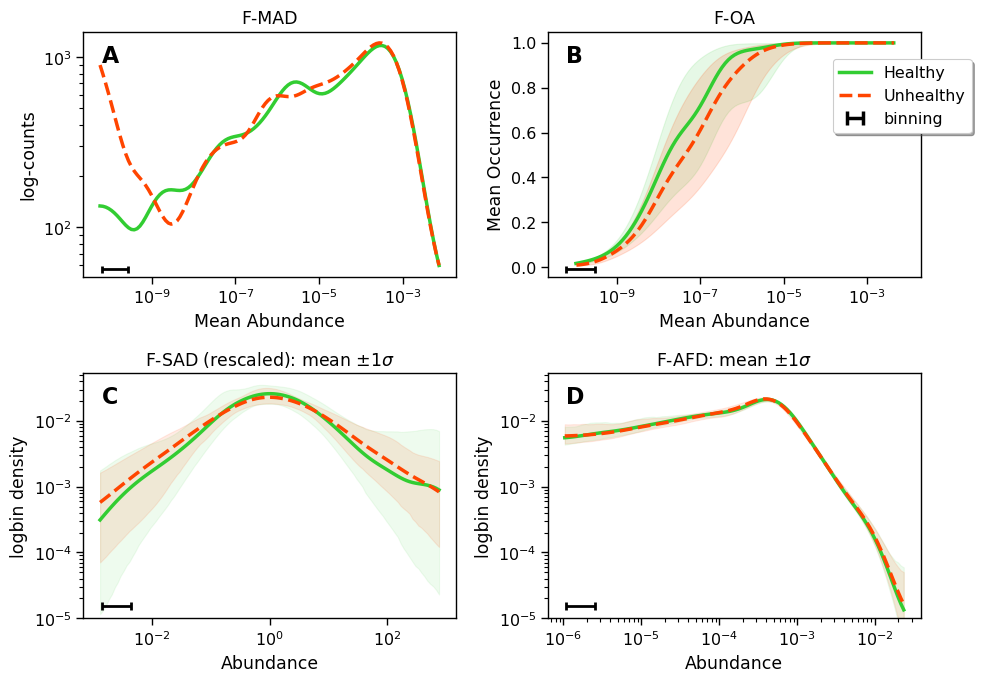

In [10]:
def plot_figure_2(DATA,savepath=None,show=True,suptitle=None,show_counts=False):

    import matplotlib as mpl
    import seaborn as sns
    sns.set_context('paper', font_scale=1.3)
    
    # unpack
    OA,MAD,SAD,AFD = DATA


    ## SHARED PARAMS

    # define colors
    Hcol=np.minimum(1,np.array(mpl.colors.to_rgba("aqua"))*0.8) #"dodgerblue"
    Ucol=np.minimum(1,np.array(mpl.colors.to_rgba("gold"))*0.9) #"darkorange"
    Hcol[-1]=1 # no "native" transparency on color 
    Ucol[-1]=1 # no "native" transparency on color
    Hcol="limegreen"
    Ucol="orangered"

    
    # define default value for params
    params = {}
    params["H"] = { "linestyle" : "-" , 
                    "alpha"     : 1 ,
                    "linewidth" : 2.5,
                    "color"     : Hcol  }
    params["U"] = { "linestyle" : "--" , 
                    "alpha"     : 1 ,
                    "linewidth" : 2.5,
                    "color"     : Ucol  }

    ## SUBPLOTS
    fig, axs = plt.subplots(2,2,figsize=[10,7])

    # suptitle
    if suptitle is not None:
        fig.suptitle(suptitle)

    # setup shared axis
    axs[0,0].sharex(axs[0,1])
    axs[1,0].sharey(axs[1,1])


    ## PLOT PLOTS

    # (0,0) MAD
    visualize_MAD(MAD,title="F-MAD",ax=axs[0,0],params=params,show_counts=show_counts)

    # (0,1) OA
    visualize_OA(*OA,title="F-OA",ax=axs[0,1],left_crop=1e-10,showerror=True,scatterplot=False,params=params)  # left_crop=1e-7 (for unnormalized functional table)

    n_sampl = 0
    logy    = True
    showerror = True

    # (1,0) SAD 
    visualize_marginal(SAD,ax=axs[1,0],kind="SAD",n_sampl=n_sampl,logy=logy,showerror=showerror,params=params)
    axs[1,0].set_title("F-SAD (rescaled): mean $\pm 1\sigma$")

    # (1,1) AFD
    visualize_marginal(AFD,ax=axs[1,1],kind="AFD",n_sampl=n_sampl,logy=logy,showerror=showerror,params=params)
    axs[1,1].set_title("F-AFD: mean $\pm 1\sigma$")
    

    ## TWEAK
    
    # legend
    axs[0,1].plot([],[],linestyle="-" ,linewidth=2.5,color=Hcol,label="Healthy")
    axs[0,1].plot([],[],linestyle="--",linewidth=2.5,color=Ucol,label="Unhealthy")
    axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.95, 0.92),ncol=1, fancybox=True, shadow=True)

    # subplot name patches
    for ax,label in zip(axs.ravel(),('A', 'B', 'C', 'D')):
        ax.text(x=0.05, y=0.95, s=label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')

    fig.tight_layout()

    # export images/display
    if savepath is not None: plt.savefig(fname=savepath, dpi="figure", format="pdf")
    
    if show: plt.show()
    else:    plt.close()


#DATA = compute_figure_2(dataset,ishealthy,nbins=12,window=1,resolution=10)
savepath = "../RESULTS/Figure_2_macroecological_patterns.pdf"
plot_figure_2(DATA,savepath=savepath,show_counts=True)